## Data Preprocessing

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

# nltk.download('stopwords')
# nltk.download('punkt')

In [2]:
def Preprocessing(txt):
    txt = str(txt).replace('\\',' ')
    
    #Tokenize
    tokens = [word for sentence in nltk.sent_tokenize(txt)
              for word in nltk.word_tokenize(sentence)]
    

    #Removing non Alphabet
    tokens = [word for word in tokens if word.isalpha()]
    
    #Removing Stopwords
    stopword = stopwords.words('english')
    tokens = [word for word in tokens if word not in stopword]
    
    #Lowercasing
    tokens = [word.lower() for word in tokens]
    
    #Stemming
    stemmer = PorterStemmer()
    tokens = [ stemmer.stem(word) for word in tokens]
    
    return tokens

def bigram(tokens):
    
    bigram =[]
    
    for i in range(len(tokens) -1):
        bigram.append(tokens[i] + " " +tokens[i+1])
    return bigram

In [3]:
import pandas as pd

test_data = pd.read_csv('data/test.csv',names = ["class","title","body"])
train_data = pd.read_csv('data/train.csv',names = ["class","title","body"])

In [4]:
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [5]:
train_X, train_Y = [],[]
test_X,  test_Y = [],[]

In [6]:
for i, row in tqdm(train_data.iterrows()):
    #print(type(tokenize(row['title'])))
    tokens = Preprocessing(row['title']) + bigram(Preprocessing(row['title'])) + Preprocessing(row['body']) + bigram(Preprocessing(row['body']))
    #tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    train_X.append(tokens)
    train_Y.append(row['class']-1)

120000it [06:19, 316.40it/s]


In [7]:
for i, row in tqdm(test_data.iterrows()):
    #print(type(tokenize(row['title'])))
    tokens = Preprocessing(row['title']) + bigram(Preprocessing(row['title'])) + Preprocessing(row['body']) +bigram(Preprocessing(row['body']))
    #tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    test_X.append(tokens)
    test_Y.append(row['class']-1)

7600it [00:24, 311.37it/s]


In [8]:
import json

train_data = {"train_X":train_X, "train_Y":train_Y }
test_data  = {"test_X":test_X, "test_Y":test_Y}

with open('traindata.json','w') as outfile:
    json.dump(train_data,outfile,indent=4)

with open('testdata.json','w') as outfile:
    json.dump(test_data,outfile,indent=4)

## Modeling

In [6]:
import json

with open('traindata.json') as jsonfile:
    traindata = json.load(jsonfile)

with open('testdata.json') as jsonfile:
    testdata = json.load(jsonfile)

In [7]:
train_X = traindata['train_X']
train_y = traindata['train_Y']

test_X = testdata['test_X']
test_y = testdata['test_Y']

In [8]:
from keras.utils import np_utils

train_y=np_utils.to_categorical(train_y, 4)
test_y=np_utils.to_categorical(test_y, 4)

Using TensorFlow backend.


### 1. one hot encoding

In [18]:
X = train_X[:5000] #12만개 x 11만개단어 one hot encoding 메모리 할당불가...
y = train_y[:5000]

In [19]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X)
word_id = tokenizer.word_index
len(word_id)

101081

In [20]:
from keras.preprocessing import sequence

seq=tokenizer.texts_to_sequences(X)

In [21]:
import numpy as np
x = np.zeros((5000,80000))
for n,s in tqdm(enumerate(seq)):
    for ss in s: 
        x[n][s]+=1

5000it [00:02, 1717.36it/s]


In [198]:
# train_one_hot = np.zeros((60000,30,2000))
# for i,s in tqdm(enumerate(seq)):
#     for j,ss in enumerate(s): ##j는30까지
#         if ss==0: continue
#         train_one_hot[i][j][ss]=1

In [22]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding,Dropout
model=Sequential()
# model.add(Embedding(100000,50,input_length=500))
# model.add(Dropout(0.7))
# model.add(Flatten())
model.add(Dense(10000, input_dim=80000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
result=model.fit(x, y, epochs=10,batch_size=32, validation_split=0.15)

Train on 4250 samples, validate on 750 samples
Epoch 1/10
4250/4250 [==============================] - 21s 5ms/step - loss: 3.4372 - acc: 0.7209 - val_loss: 0.5256 - val_acc: 0.8627
Epoch 2/10
4250/4250 [==============================] - 20s 5ms/step - loss: 0.3748 - acc: 0.9341 - val_loss: 1.0250 - val_acc: 0.8533
Epoch 3/10
4250/4250 [==============================] - 19s 5ms/step - loss: 0.1865 - acc: 0.9769 - val_loss: 1.3318 - val_acc: 0.8667
Epoch 4/10
4250/4250 [==============================] - 19s 4ms/step - loss: 0.1107 - acc: 0.9918 - val_loss: 1.3839 - val_acc: 0.8600
Epoch 5/10
4250/4250 [==============================] - 19s 4ms/step - loss: 0.0987 - acc: 0.9948 - val_loss: 1.6764 - val_acc: 0.8467
Epoch 6/10
4250/4250 [==============================] - 19s 4ms/step - loss: 0.0377 - acc: 0.9969 - val_loss: 2.1716 - val_acc: 0.8560
Epoch 7/10
4250/4250 [==============================] - 19s 4ms/step - loss: 0.0614 - acc: 0.9969 - val_loss: 2.1962 - val_acc: 0.8640
Epoch 8/

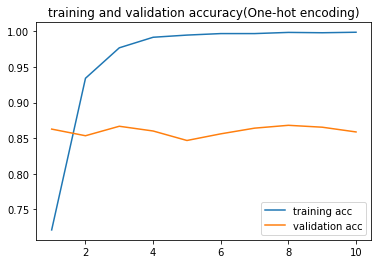

In [27]:
import matplotlib.pyplot as plt
acc=result.history['acc']
val_acc=result.history['val_acc']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy(One-hot encoding)')
plt.legend()
# plt.figure()
# plt.plot(epochs,loss,label='training loss')
# plt.plot(epochs,val_loss,label='validation loss')
# plt.title('training and validation loss')
# plt.legend()
# plt.show()

In [156]:
t_X = test_X[:2000] 
t_y = test_y[:2000]

t_seq=tokenizer.texts_to_sequences(t_X)

import numpy as np
t_x = np.zeros((2000,80000))
for n,s in tqdm(enumerate(t_seq)):
    for ss in s: 
        t_x[n][s]+=1

2000it [00:00, 2928.34it/s]


In [163]:
predict_y = model.predict(t_x)

In [172]:
import tensorflow as tf

with tf.compat.v1.Session() :
    tf.argmax(predict_y,1).eval()
    argm = tf.equal(tf.argmax(t_y, 1), tf.argmax(predict_y, 1)) #맞으면 1
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) #평균

argmax accuracy: 0.8495


### 2. Hashing Trick

In [9]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=100000)
tokenizer.fit_on_texts(train_X)
word_id = tokenizer.word_index
len(word_id)

1165540

In [10]:
def make_dictionary(data):
    dictionary_list = []
    for sentence in tqdm(data):
        dic = dict()
        for word in sentence:
            try:
                dic[word] += 1
            except:
                dic[word] = 1
        dictionary_list.append(dic)
    return dictionary_list
    
train_dict = make_dictionary(traindata['train_X'])
test_dict = make_dictionary(testdata['test_X'])

100%|██████████| 7600/7600 [00:00<00:00, 58580.10it/s]


In [11]:
from sklearn.feature_extraction import FeatureHasher

Hasher = FeatureHasher(n_features = 100000) #n_features=len(word_id) 1165541
Hasher.fit(train_dict)

FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
              input_type='dict', n_features=100000)

In [12]:
H=Hasher.transform(train_dict)

In [13]:
H.shape 
#one-hot encoding은 120000개x100000단어 메모리 지원 X - 5000개로자름
#hasher통해선 가능: hashing통해 메모리줄임

(120000, 100000)

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding,Dropout
model_h=Sequential()
model_h.add(Dense(1000, input_dim=100000, activation='relu'))
model_h.add(Dropout(0.7))
model_h.add(Dense(500, activation='relu'))
model_h.add(Dropout(0.7)) 
model_h.add(Dense(100, activation='relu'))
model_h.add(Dropout(0.7)) 
model_h.add(Dense(4, activation='softmax'))

In [19]:
model_h.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
result=model_h.fit(H, train_y, epochs=20,batch_size=32, validation_split=0.15)

Train on 102000 samples, validate on 18000 samples
Epoch 1/20
102000/102000 [==============================] - 105s 1ms/step - loss: 0.5911 - acc: 0.9000 - val_loss: 0.6601 - val_acc: 0.8992
Epoch 2/20
102000/102000 [==============================] - 105s 1ms/step - loss: 0.6057 - acc: 0.9015 - val_loss: 0.5330 - val_acc: 0.9004
Epoch 3/20
102000/102000 [==============================] - 123s 1ms/step - loss: 0.6090 - acc: 0.9012 - val_loss: 0.5835 - val_acc: 0.9014
Epoch 4/20
102000/102000 [==============================] - 176s 2ms/step - loss: 0.6303 - acc: 0.9025 - val_loss: 0.5751 - val_acc: 0.8972
Epoch 5/20
102000/102000 [==============================] - 179s 2ms/step - loss: 0.6475 - acc: 0.9045 - val_loss: 0.5562 - val_acc: 0.9016
Epoch 6/20
102000/102000 [==============================] - 180s 2ms/step - loss: 0.6641 - acc: 0.9052 - val_loss: 0.5798 - val_acc: 0.8971
Epoch 7/20
102000/102000 [==============================] - 179s 2ms/step - loss: 0.6698 - acc: 0.9053 - val_

Text(0.5, 1.0, 'training and validation accuracy(Hashing)')

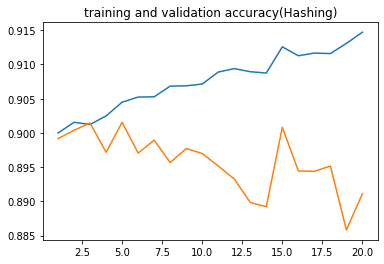

In [20]:
import matplotlib.pyplot as plt
acc=result.history['acc']
val_acc=result.history['val_acc']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy(Hashing)')
# plt.legend()
# plt.figure()
# plt.plot(epochs,loss,label='training loss')
# plt.plot(epochs,val_loss,label='validation loss')
# plt.title('training and validation loss')
# plt.legend()
# plt.show()

In [21]:
t_H=Hasher.transform(test_dict)

In [22]:
predict_yh = model_h.predict(t_H)

In [27]:
with tf.compat.v1.Session() :
    tf.argmax(predict_yh,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_yh, 1)) #맞으면 1
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) #평균

accuracy: 0.8880263


## 3. Glove
bigram은 생략

#### Preprocessing

In [28]:
import pandas as pd

test_data = pd.read_csv('data/test.csv',names = ["class","title","body"])
train_data = pd.read_csv('data/train.csv',names = ["class","title","body"])

train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [29]:
gl_train_X, gl_train_Y = [],[]
gl_test_X,  gl_test_Y = [],[]

In [30]:
for i, row in tqdm(train_data.iterrows()):
#     tokens = Preprocessing(row['title']) + bigram(Preprocessing(row['title'])) + Preprocessing(row['body']) + bigram(Preprocessing(row['body']))
    tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    gl_train_X.append(tokens)
    gl_train_Y.append(row['class']-1)

120000it [03:20, 597.18it/s]


In [31]:
for i, row in tqdm(test_data.iterrows()):
#     tokens = Preprocessing(row['title']) + bigram(Preprocessing(row['title'])) + Preprocessing(row['body']) +bigram(Preprocessing(row['body']))
    tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    gl_test_X.append(tokens)
    gl_test_Y.append(row['class']-1)

7600it [00:12, 601.09it/s]


In [32]:
import json

gl_train_data = {"train_X":gl_train_X, "train_Y":gl_train_Y }
gl_test_data  = {"test_X":gl_test_X, "test_Y":gl_test_Y}

with open('gl_traindata.json','w') as outfile:
    json.dump(gl_train_data,outfile,indent=4)

with open('gl_testdata.json','w') as outfile:
    json.dump(gl_test_data,outfile,indent=4)

Get Data

In [1]:
import json

with open('gl_traindata.json') as jsonfile:
    gl_traindata = json.load(jsonfile)

with open('gl_testdata.json') as jsonfile:
    gl_testdata = json.load(jsonfile)

In [2]:
train_X = gl_traindata['train_X']
train_y = gl_traindata['train_Y']

test_X = gl_testdata['test_X']
test_y = gl_testdata['test_Y']

In [3]:
from keras.utils import np_utils

train_y=np_utils.to_categorical(train_y, 4)
test_y=np_utils.to_categorical(test_y, 4)

Using TensorFlow backend.


In [4]:
print(len(train_X),len(test_X))

120000 7600


#### Modeling

In [5]:
import numpy as np
embeddings_index = dict()

f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [6]:
gl_words = list(embeddings_index.keys())
len(gl_words)

400000

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = len(gl_words))
tokenizer.fit_on_texts(gl_words)

In [8]:
n = len(gl_words)
embedding_matrix = np.zeros((n, 300)) 
for word, index in tokenizer.word_index.items():
    if index > n - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(400000, 300)


In [9]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(train_X)
data = pad_sequences(sequences, maxlen=maxlen)
data.shape

(120000, 500)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Activation
from keras.layers import BatchNormalization,Dropout
# from keras.layers import LSTM

In [43]:
model_gl=Sequential()
model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_gl.add(Flatten())
model_gl.add(Dropout(0.7))
model_gl.add(Dense(500,activation='relu'))
model_gl.add(Dropout(0.7))
model_gl.add(Dense(100,activation='relu'))
model_gl.add(Dropout(0.7))
model_gl.add(Dense(100,activation='relu'))
model_gl.add(Dropout(0.7))
model_gl.add(Dense(4,activation='softmax')) 

model_gl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
result=model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 20)

Train on 84000 samples, validate on 36000 samples
Epoch 1/20
84000/84000 [==============================] - 49s 581us/step - loss: 0.8603 - accuracy: 0.6693 - val_loss: 0.5192 - val_accuracy: 0.8504
Epoch 2/20
84000/84000 [==============================] - 49s 583us/step - loss: 0.6765 - accuracy: 0.7728 - val_loss: 0.4967 - val_accuracy: 0.8507
Epoch 3/20
84000/84000 [==============================] - 49s 578us/step - loss: 0.6563 - accuracy: 0.7822 - val_loss: 0.4763 - val_accuracy: 0.8531
Epoch 4/20
84000/84000 [==============================] - 49s 581us/step - loss: 0.6460 - accuracy: 0.7866 - val_loss: 0.4762 - val_accuracy: 0.8554
Epoch 5/20
84000/84000 [==============================] - 49s 579us/step - loss: 0.6329 - accuracy: 0.7918 - val_loss: 0.4842 - val_accuracy: 0.8554
Epoch 6/20
84000/84000 [==============================] - 48s 571us/step - loss: 0.6264 - accuracy: 0.7929 - val_loss: 0.4588 - val_accuracy: 0.8576
Epoch 7/20
84000/84000 [==============================] 

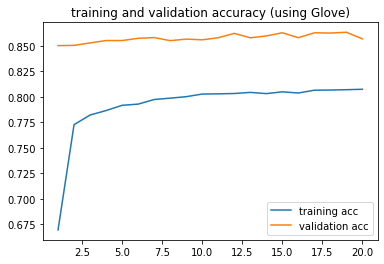

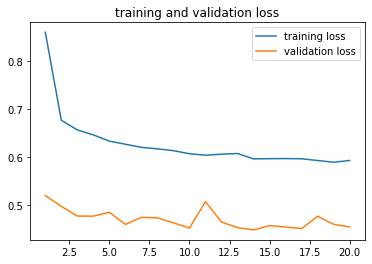

In [45]:
import matplotlib.pyplot as plt
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (using Glove)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

valid가더크다?!

In [11]:
from keras import optimizers

In [12]:
def train_and_validate(num_hlayers, dropout, epoch, learnrate):
    # from keras.layers import LSTM
    model_gl=Sequential()
    model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model_gl.add(Flatten())
    for i in range(num_hlayers): 
        model_gl.add(Dropout(dropout))
        model_gl.add(Dense(int(500/(i+1)),kernel_initializer='he_normal'))
        model_gl.add(BatchNormalization())
        model_gl.add(Activation('relu'))
    model_gl.add(Dense(4,activation='softmax')) 
    
    adam = optimizers.Adam(lr=learnrate)
    model_gl.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    mod = model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = int(epoch), verbose=0)
    
    score = max(mod.history['val_accuracy'])
    
    return score
    

In [13]:
from bayes_opt import BayesianOptimization

pb={'num_hlayers':(1,6),
    'dropout':(0.5,0.75),
    'epoch':(10,30),
    'learnrate':(1e-4, 1e-1)}

optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds=pb,
    random_state=0,
    verbose=2
)

optimizer.maximize(init_points=5,n_iter=10)

for i,res in enumerate(optimizer.res):
    print('Iteration {}: \n\t{}'.format(i,res))
print()
print()
print('Final result: ',optimizer.max)

|   iter    |  target   |  dropout  |   epoch   | learnrate | num_hl... |
-------------------------------------------------------------------------
|  1        |  0.8793   |  0.6372   |  24.3     |  0.06032  |  3.724    |
|  2        |  0.8772   |  0.6059   |  22.92    |  0.04381  |  5.459    |
|  3        |  0.8708   |  0.7409   |  17.67    |  0.07919  |  3.644    |
|  4        |  0.8211   |  0.642    |  28.51    |  0.007197 |  1.436    |
|  5        |  0.8787   |  0.5051   |  26.65    |  0.07784  |  5.35     |
|  6        |  0.8709   |  0.5      |  10.0     |  0.0001   |  1.0      |
|  7        |  0.2516   |  0.75     |  10.0     |  0.1      |  6.0      |
|  8        |  0.8717   |  0.5      |  18.16    |  0.0001   |  1.0      |
|  9        |  0.7977   |  0.75     |  30.0     |  0.0001   |  6.0      |
|  10       |  0.8189   |  0.75     |  13.71    |  0.1      |  1.0      |
|  11       |  0.8202   |  0.5      |  23.06    |  0.1      |  1.0      |
|  12       |  0.8783   |  0.5      | 

'dropout': 0.5, 'epoch': 27, 'learnrate': 0.0195, 'num_hlayers': 3

In [19]:
#Apply
model_gl=Sequential()
model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_gl.add(Flatten())
for i in range(3): 
    model_gl.add(Dropout(0.6)) #overfitting 방지
    model_gl.add(Dense(int(500/(i+1)),kernel_initializer='he_normal'))
    model_gl.add(BatchNormalization())
    model_gl.add(Activation('relu'))
model_gl.add(Dense(4,activation='softmax')) 

adam = optimizers.Adam(lr=0.0195)
model_gl.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
result=model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 27)

Train on 84000 samples, validate on 36000 samples
Epoch 1/27
84000/84000 [==============================] - 59s 697us/step - loss: 0.6049 - accuracy: 0.7822 - val_loss: 0.4176 - val_accuracy: 0.8610
Epoch 2/27
84000/84000 [==============================] - 57s 675us/step - loss: 0.5188 - accuracy: 0.8156 - val_loss: 0.3922 - val_accuracy: 0.8662
Epoch 3/27
84000/84000 [==============================] - 58s 686us/step - loss: 0.4956 - accuracy: 0.8218 - val_loss: 0.3780 - val_accuracy: 0.8684
Epoch 4/27
84000/84000 [==============================] - 58s 693us/step - loss: 0.4770 - accuracy: 0.8284 - val_loss: 0.3838 - val_accuracy: 0.8661
Epoch 5/27
84000/84000 [==============================] - 58s 686us/step - loss: 0.4579 - accuracy: 0.8342 - val_loss: 0.3632 - val_accuracy: 0.8725
Epoch 6/27
84000/84000 [==============================] - 57s 681us/step - loss: 0.4478 - accuracy: 0.8373 - val_loss: 0.3655 - val_accuracy: 0.8715
Epoch 7/27
84000/84000 [==============================] 

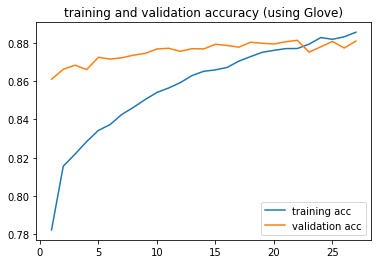

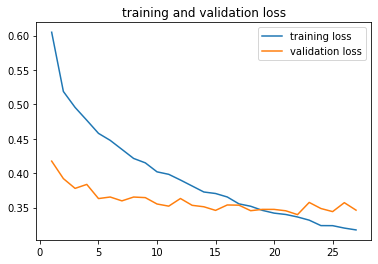

In [21]:
import matplotlib.pyplot as plt
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (using Glove)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [22]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(test_X)
test_data = pad_sequences(sequences, maxlen=maxlen)
test_data.shape

(7600, 500)

In [23]:
predict_ygl = model_gl.predict(test_data)

In [26]:
with tf.compat.v1.Session() :
    tf.argmax(predict_ygl,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_ygl, 1)) #맞으면 1
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) #평균

accuracy: 0.8756579
